In [1]:
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import scipy.io, cv2

# Find images path
images_paths = glob('../Dataset_Final/jpg_images/*/*')

# Fulfill data
X_ = []
y_ = []
for path in images_paths:
    scene = path.split('/')[-2]
    
    # Input data (images)
    img = plt.imread(path)
    # Image resize
    if 0:
        img = cv2.resize(img, dsize = None,fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)
    
    X_.append(img[0:256,0:256,:])
    
    # Output data (NLFs)
    nlf_path = '../Dataset_Final/NLFs/NLF_' + scene + '.mat'
    mat = scipy.io.loadmat('../Dataset_Final/NLFs/NLF_' + scene + '.mat')
    NLF = mat["NLF"][0]
    y_.append(np.nan_to_num(NLF))
    
#(X_train, y_train), (X_test, y_test) = ''

In [2]:
X_ = np.asarray(X_)
y_ = np.asarray(y_)


In [3]:
print(np.shape(X_))

(327, 256, 256, 3)


### Crear modelo

In [5]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Reshape
from keras.layers import concatenate, AveragePooling2D, Activation, BatchNormalization
from keras.models import Model
from SpatialPyramidPooling import SpatialPyramidPooling
import keras
# First, define the vision modules
input_imgs = Input(shape=(None, None, 3))

# Model
def get_model_column(ks_1, ks_2,p_):
    x = Conv2D(64, kernel_size=(ks_1,ks_1), strides = 2, activation=None)(input_imgs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D((2, 2))(x)
    x = Conv2D(64, kernel_size=(ks_2,ks_2), activation=None)(x) # conv2_a
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D((2, 2))(x) # pool2_a
    x = Conv2D(64, kernel_size=(ks_2,ks_2), activation=None)(x) # conv2_a
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, kernel_size=(ks_2,ks_2), activation=None)(x) # conv2_a
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    out = keras.layers.ZeroPadding2D(padding=((p_, 0), (0, p_)), data_format=None)(x)
    #out1 = Flatten()(x)
    return out

vision_model1 = Model(input_imgs, get_model_column(5, 3,0))
vision_model2 = Model(input_imgs, get_model_column(7, 5,5))
vision_model3 = Model(input_imgs, get_model_column(9, 7,10))

# Then define the input-apart model
input_a = Input(shape=(256, 256, 3))
input_b = Input(shape=(256, 256, 3)) #shape=(300, 300, 3))
input_c = Input(shape=(256, 256, 3)) #shape=(340, 340, 3))

# The vision model will be shared, weights and all
out_a = vision_model1(input_a)
out_b = vision_model2(input_b)
out_c = vision_model3(input_c)

concatenated = concatenate([out_a, out_b, out_c],axis=2)
#out = Dense(1, activation='sigmoid')(concatenated)
merge_abc = SpatialPyramidPooling([1, 2, 4])(concatenated)
merge_abc = Dense(2048, activation='relu')(merge_abc)
merge_abc = Dense(256*3, activation='relu')(merge_abc)

model_abc = Model([input_a, input_b, input_c], merge_abc)

In [6]:
model_abc.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 multiple             116672      input_3[0][0]                    
__________________________________________________________________________________________________
model_2 (M

### Training

In [7]:
from keras import optimizers

sgd = optimizers.SGD(lr=0.001, decay=0.0001, momentum=0.9, nesterov=True)

# compile model (abc)
model_abc.compile(optimizer= sgd, loss='mse')

In [8]:
# Make model_a non trainable
model_abc.layers[3].trainable = False
model_abc.layers[4].trainable = False
model_abc.fit(x=[X_,X_,X_], y=y_, batch_size=32, epochs=20, validation_split=0.1, shuffle=True)

# Make model_a non trainable
model_abc.layers[3].trainable = False
model_abc.layers[4].trainable = True
model_abc.layers[5].trainable = False
model_abc.fit(x=[X_,X_,X_], y=y_, batch_size=32, epochs=20, validation_split=0.1, shuffle=True)

# Make model_a non trainable
model_abc.layers[3].trainable = True
model_abc.layers[4].trainable = False
model_abc.layers[5].trainable = False
model_abc.fit(x=[X_,X_,X_], y=y_, batch_size=32, epochs=20, validation_split=0.1, shuffle=True)


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


/home/plyzer-ai/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 294 samples, validate on 33 samples
Epoch 1/20
294/294 [==============================] - 40s 137ms/step - loss: 0.5679 - val_loss: 29.6547
Epoch 2/20
294/294 [==============================] - 44s 150ms/step - loss: 0.1446 - val_loss: 30.8649
Epoch 3/20
294/294 [==============================] - 44s 151ms/step - loss: 0.0595 - val_loss: 29.2604
Epoch 4/20
294/294 [==============================] - 43s 146ms/step - loss: 0.0333 - val_loss: 27.2063
Epoch 5/20
294/294 [==============================] - 44s 149ms/step - loss: 0.0221 - val_loss: 25.3723
Epoch 6/20
294/294 [==============================] - 45s 153ms/step - loss: 0.0162 - val_loss: 23.9202
Epoch 7/20
294/294 [==============================] - 43s 147ms/step - loss: 0.0124 - val_loss: 22.7556
Epoch 8/20
294/294 [==============================] - 44s 149ms/step - loss: 0.0095 - val_loss: 21.7851
Epoch 9/20
294/294 [==============================] - 45s 152ms/step - loss: 0.0082 - val_loss: 20.9991
Epoch 10/20
294/294

In [9]:

(model_abc.predict([[X_[0]],[X_[0]],[X_[0]]]))

array([[-0.0000000e+00,  2.0554407e+00, -0.0000000e+00,  6.9410753e-01,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,  6.1631556e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,  3.1604643e+00,
         1.1926466e+01, -0.0000000e+00, -0.0000000e+00,  5.0845714e+00,
         2.0509393e+00,  3.0089989e-01,  6.6392845e-01, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
         2.1485674e+00,  2.9884630e-01,  4.1762280e+00, -0.0000000e+00,
         2.4672391e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,  7.0057063e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,  2.0242031e-01,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.00000

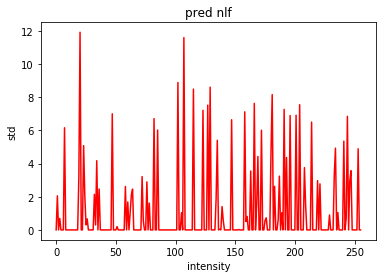

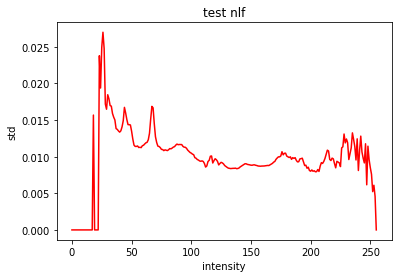

In [24]:
import matplotlib.pyplot as plt
y_pred = np.transpose(model_abc.predict([[X_[0]],[X_[0]],[X_[0]]]))

fig, ax = plt.subplots()
ax.plot(y_pred[0:256],'r')

ax.set(xlabel='intensity', ylabel='std',
       title='pred nlf')
plt.show()

fig, ax = plt.subplots()
ax.plot(y_[0][0:256],'r')

ax.set(xlabel='intensity', ylabel='std',
       title='test nlf')
plt.show()

In [9]:
from keras.utils import plot_model

plot_model(model_abc, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [9]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']